In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import lognorm, truncnorm, triang
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
# Load the Excel data
file_path = 'carcinogenic_monte_carlo_dataset.xlsx'
fuchka_data = pd.read_excel(file_path, sheet_name='Metal_Concentration_Fuchka', header=1)
tamarind_data = pd.read_excel(file_path, sheet_name='Metal_Concentration_Tamarind', header=1)

In [4]:
# Clean column names and data
fuchka_data.columns = ['Sample_ID', 'Pb', 'Cd', 'Cr', 'Ni']
tamarind_data.columns = ['Sample_ID', 'Pb', 'Cd', 'Cr', 'Ni', 'As']

In [5]:
# Remove any non-numeric rows
fuchka_data = fuchka_data[pd.to_numeric(fuchka_data['Sample_ID'], errors='coerce').notna()]
tamarind_data = tamarind_data[pd.to_numeric(tamarind_data['Sample_ID'], errors='coerce').notna()]

In [6]:
print("Fuchka Data Shape:", fuchka_data.shape)
print("Tamarind Data Shape:", tamarind_data.shape)
print("\nFuchka Data Preview:")
print(fuchka_data.head())
print("\nTamarind Data Preview:")
print(tamarind_data.head())

Fuchka Data Shape: (42, 5)
Tamarind Data Shape: (42, 6)

Fuchka Data Preview:
   Sample_ID       Pb     Cd      Cr      Ni
0          1  1790.62  48.04  141.16  462.26
1          2    86.32   1.00   10.00   10.00
2          3  1190.14  29.58  101.52  317.98
3          4    10.00   1.00  142.34  233.06
4          5    10.00   1.00  116.78  261.96

Tamarind Data Preview:
   Sample_ID         Pb       Cd        Cr       Ni       As
0          1     1.2500   2.0475  18.86625  21.9550  17.6150
1          2     1.2500  13.3380  37.70625   1.2500   1.2500
2          3     1.2500   1.8720  68.57625  20.0025  91.1475
3          4     1.2500   6.4350  14.78875   5.6875   1.2500
4          5  2689.8975   7.8000  24.04875  52.7925   1.2500


In [7]:
# Parameters from the dataset
PARAMETERS = {
    'adult': {
        'ED': 70,  # Exposure Duration (years)
        'EFr': 365,  # Exposure Frequency (days/year)
        'AT': 70 * 365,  # Averaging Time (days)
        'BW': 70,  # Body Weight (kg) - mean for distribution
        'FIR_fuchka': 0.1,  # Food Ingestion Rate Fuchka (kg/day)
        'FIR_tamarind': 0.03  # Food Ingestion Rate Tamarind (L/day)
    },
    'child': {
        'ED': 6,  # Exposure Duration (years)
        'EFr': 365,  # Exposure Frequency (days/year)
        'AT': 6 * 365,  # Averaging Time (days)
        'BW': 24,  # Body Weight (kg) - mean for distribution
        'FIR_fuchka': 0.1,  # Food Ingestion Rate Fuchka (kg/day)
        'FIR_tamarind': 0.03  # Food Ingestion Rate Tamarind (L/day)
    }
}

In [8]:
# Cancer Slope Factors (CSF) - (µg/kg/day)⁻¹
CSF = {
    'As': 0.0015,
    'Ni': 0.00091,
    'Cd': 0.0063,
    'Pb': 0.0085,
    'Cr': 0.0005
}

In [9]:
# Monte Carlo simulation parameters
N_ITERATIONS = 10000

In [10]:
def generate_distributions(age_group, n_samples):
    """Generate random samples for varying parameters"""
    
    # Body Weight - Truncated Normal Distribution
    if age_group == 'adult':
        bw_lower, bw_upper = 45, 100
        bw_mean, bw_std = 70, 10
    else:  # child
        bw_lower, bw_upper = 20, 50
        bw_mean, bw_std = 24, 5
    
    # Standardize for truncated normal
    a, b = (bw_lower - bw_mean) / bw_std, (bw_upper - bw_mean) / bw_std
    bw_samples = truncnorm.rvs(a, b, loc=bw_mean, scale=bw_std, size=n_samples)
    
    # Food Ingestion Rates - Triangular Distribution
    # Using mean ± 20% for triangular distribution bounds
    fir_fuchka_mean = PARAMETERS[age_group]['FIR_fuchka']
    fir_fuchka_lower = fir_fuchka_mean * 0.8
    fir_fuchka_upper = fir_fuchka_mean * 1.2
    fir_fuchka_samples = triang.rvs(
        c=0.5, loc=fir_fuchka_lower, 
        scale=fir_fuchka_upper - fir_fuchka_lower, 
        size=n_samples
    )
    
    fir_tamarind_mean = PARAMETERS[age_group]['FIR_tamarind']
    fir_tamarind_lower = fir_tamarind_mean * 0.8
    fir_tamarind_upper = fir_tamarind_mean * 1.2
    fir_tamarind_samples = triang.rvs(
        c=0.5, loc=fir_tamarind_lower,
        scale=fir_tamarind_upper - fir_tamarind_lower,
        size=n_samples
    )
    
    return {
        'BW': bw_samples,
        'FIR_fuchka': fir_fuchka_samples,
        'FIR_tamarind': fir_tamarind_samples
    }

In [11]:
def generate_metal_concentrations(data, metal, n_samples):
    """Generate lognormal distribution samples for metal concentrations"""
    concentrations = data[metal].values
    # Remove zeros and very low values for lognormal fitting
    concentrations = concentrations[concentrations > 0.1]
    
    # Fit lognormal distribution
    sigma, loc, scale = lognorm.fit(concentrations, floc=0)
    
    # Generate samples
    return lognorm.rvs(sigma, loc=loc, scale=scale, size=n_samples)

In [12]:
def calculate_ilcr_single_food(metal_conc, fir, bw, ed, efr, at, csf):
    """Calculate ILCR for a single food item"""
    # ILCR = (C × FIR × EFr × ED × CSF) / (BW × AT)
    return (metal_conc * fir * efr * ed * csf) / (bw * at)

In [13]:
def run_monte_carlo_simulation():
    """Run Monte Carlo simulation for all metals and age groups"""
    
    results = {}
    metals = ['Pb', 'Cd', 'Cr', 'Ni', 'As']
    age_groups = ['adult', 'child']
    
    for age_group in age_groups:
        print(f"\nRunning simulation for {age_group.upper()}...")
        
        # Generate parameter distributions
        param_dist = generate_distributions(age_group, N_ITERATIONS)
        params = PARAMETERS[age_group]
        
        for metal in metals:
            print(f"  Processing {metal}...")
            
            ilcr_combined = np.zeros(N_ITERATIONS)
            
            # For each iteration
            for i in range(N_ITERATIONS):
                bw = param_dist['BW'][i]
                fir_fuchka = param_dist['FIR_fuchka'][i]
                fir_tamarind = param_dist['FIR_tamarind'][i]
                
                ilcr_total = 0
                
                # ILCR from Fuchka (if metal exists)
                if metal in fuchka_data.columns:
                    metal_conc_fuchka = generate_metal_concentrations(fuchka_data, metal, 1)[0]
                    # Convert μg/kg to mg/kg
                    metal_conc_fuchka_mg = metal_conc_fuchka / 1000
                    
                    ilcr_fuchka = calculate_ilcr_single_food(
                        metal_conc_fuchka_mg, fir_fuchka, bw, 
                        params['ED'], params['EFr'], params['AT'], CSF[metal]
                    )
                    ilcr_total += ilcr_fuchka
                
                # ILCR from Tamarind (if metal exists)
                if metal in tamarind_data.columns:
                    metal_conc_tamarind = generate_metal_concentrations(tamarind_data, metal, 1)[0]
                    # Convert μg/L to mg/L
                    metal_conc_tamarind_mg = metal_conc_tamarind / 1000
                    
                    ilcr_tamarind = calculate_ilcr_single_food(
                        metal_conc_tamarind_mg, fir_tamarind, bw,
                        params['ED'], params['EFr'], params['AT'], CSF[metal]
                    )
                    ilcr_total += ilcr_tamarind
                
                ilcr_combined[i] = ilcr_total
            
            results[f"{metal}_{age_group}"] = ilcr_combined
    
    return results

In [14]:
def create_cancer_risk_plot(ilcr_data, metal, age_group):
    """Create cancer risk plot as specified in the document"""
    
    plt.figure(figsize=(12, 8))
    
    # Create histogram
    n, bins, patches = plt.hist(ilcr_data, bins=50, density=True, alpha=0.7, 
                               color='red', edgecolor='black', linewidth=0.5)
    
    # Fit lognormal distribution
    sigma, loc, scale = lognorm.fit(ilcr_data, floc=0)
    
    # Generate fitted curve
    x = np.linspace(ilcr_data.min(), ilcr_data.max(), 1000)
    fitted_curve = lognorm.pdf(x, sigma, loc=loc, scale=scale)
    
    # Plot fitted curve
    plt.plot(x, fitted_curve, 'g-', linewidth=3, label='Lognormal Fit')
    
    # Calculate percentiles
    percentiles = {
        '5th': np.percentile(ilcr_data, 5),
        '50th': np.percentile(ilcr_data, 50),
        '75th': np.percentile(ilcr_data, 75),
        '95th': np.percentile(ilcr_data, 95)
    }
    
    mean_val = np.mean(ilcr_data)
    std_val = np.std(ilcr_data)
    
    # Add vertical lines for statistical markers
    colors = {'5th': 'blue', '50th': 'orange', '75th': 'purple', '95th': 'brown'}
    
    for label, value in percentiles.items():
        plt.axvline(value, color=colors[label], linestyle='--', linewidth=2, 
                   label=f'{label} percentile')
    
    # Add mean and std lines
    plt.axvline(mean_val, color='black', linestyle='-', linewidth=2, label='Mean')
    plt.axvline(mean_val + std_val, color='gray', linestyle=':', linewidth=2, label='Mean + 1σ')
    plt.axvline(mean_val - std_val, color='gray', linestyle=':', linewidth=2, label='Mean - 1σ')
    
    # Formatting
    plt.xlabel('Cancer Risk', fontsize=14, fontweight='bold')
    plt.ylabel('Probability', fontsize=14, fontweight='bold')
    
    # Create second y-axis for frequency
    ax2 = plt.gca().twinx()
    ax2.hist(ilcr_data, bins=50, alpha=0, density=False)
    ax2.set_ylabel('Frequency', fontsize=14, fontweight='bold')
    
    # Title and labels
    age_title = age_group.capitalize()
    plt.title(f'Probabilistic Cancer Risk Distribution of {metal} in {age_title}\n'
              f'Monte Carlo Simulation (10,000 iterations)', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Add certainty text
    certainty_90 = np.percentile(ilcr_data, 90)
    plt.text(0.02, 0.98, 'Certainty = 90%', transform=plt.gca().transAxes, 
             fontsize=12, fontweight='bold', verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Scientific notation for x-axis
    plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    
    # Legend
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
    
    # Grid
    plt.grid(True, alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    # Save the plot
    filename = f"{metal}_{age_title}_CancerRisk.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")
    
    plt.show()
    
    # Print statistics
    print(f"\n{metal} - {age_title} Statistics:")
    print(f"Mean: {mean_val:.3e}")
    print(f"Std: {std_val:.3e}")
    for label, value in percentiles.items():
        print(f"{label} percentile: {value:.3e}")
    print("-" * 50)

In [15]:
# Run the simulation
print("Starting Carcinogenic Monte Carlo Simulation...")
print("This may take a few minutes...")

simulation_results = run_monte_carlo_simulation()

print(f"\nSimulation complete! Generated {len(simulation_results)} result sets.")

Starting Carcinogenic Monte Carlo Simulation...
This may take a few minutes...

Running simulation for ADULT...
  Processing Pb...
  Processing Cd...
  Processing Cr...
  Processing Ni...
  Processing As...

Running simulation for CHILD...
  Processing Pb...
  Processing Cd...
  Processing Cr...
  Processing Ni...
  Processing As...

Simulation complete! Generated 10 result sets.



Generating plots...
Saved: Pb_Adult_CancerRisk.png


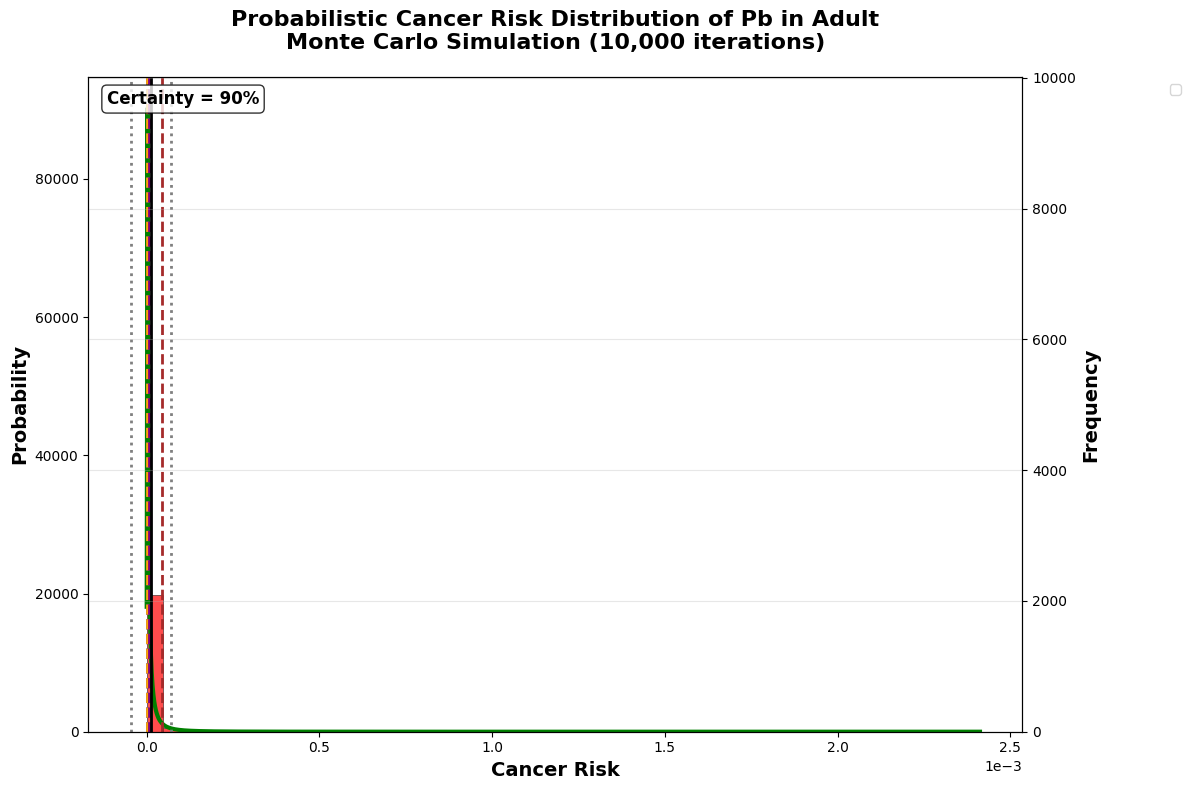


Pb - Adult Statistics:
Mean: 1.224e-05
Std: 5.878e-05
5th percentile: 1.104e-07
50th percentile: 2.025e-06
75th percentile: 7.072e-06
95th percentile: 4.546e-05
--------------------------------------------------
Saved: Pb_Child_CancerRisk.png


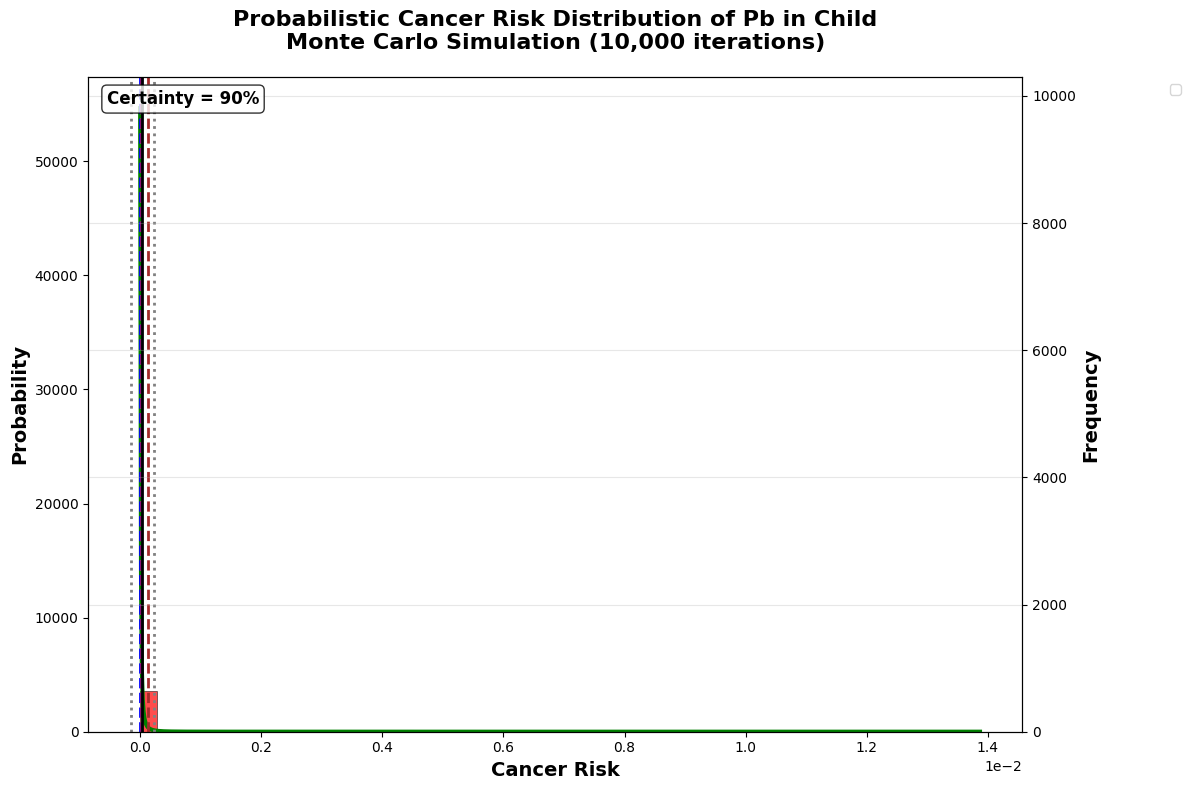


Pb - Child Statistics:
Mean: 3.234e-05
Std: 1.903e-04
5th percentile: 3.232e-07
50th percentile: 5.254e-06
75th percentile: 1.911e-05
95th percentile: 1.224e-04
--------------------------------------------------
Saved: Cd_Adult_CancerRisk.png


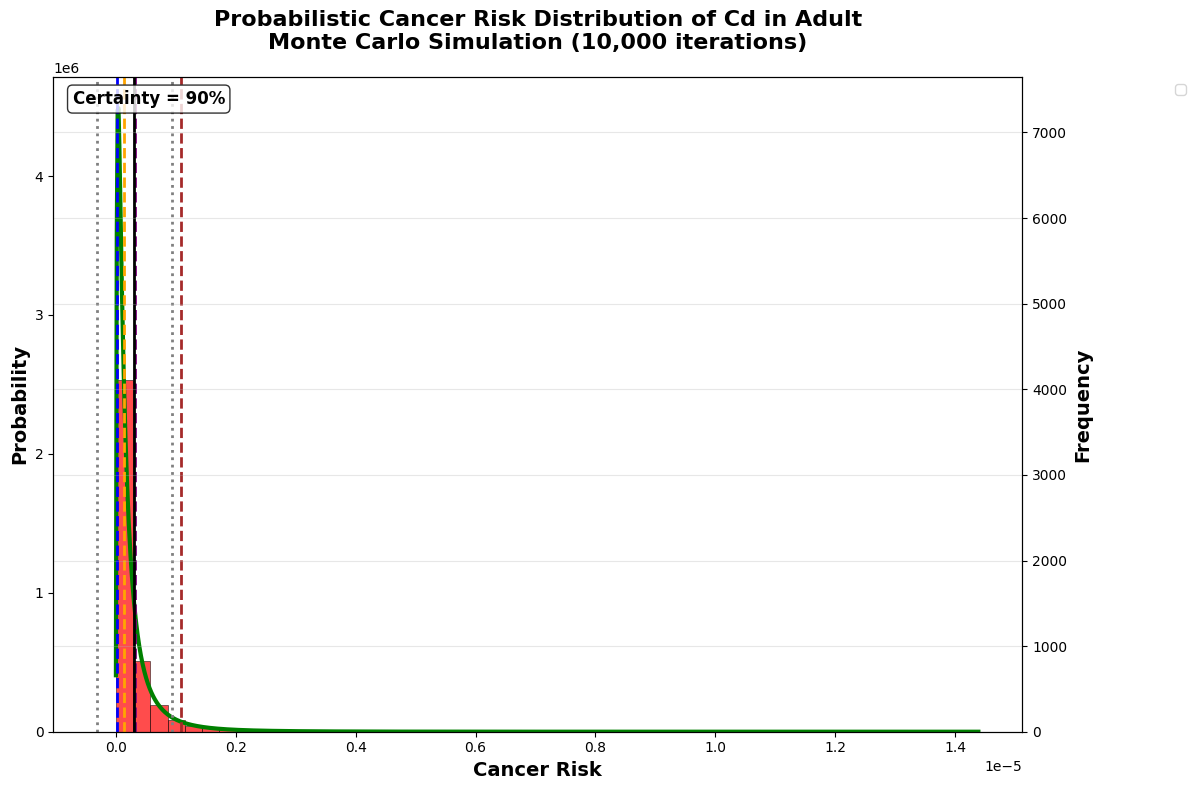


Cd - Adult Statistics:
Mean: 3.112e-07
Std: 6.199e-07
5th percentile: 2.456e-08
50th percentile: 1.390e-07
75th percentile: 3.165e-07
95th percentile: 1.095e-06
--------------------------------------------------
Saved: Cd_Child_CancerRisk.png


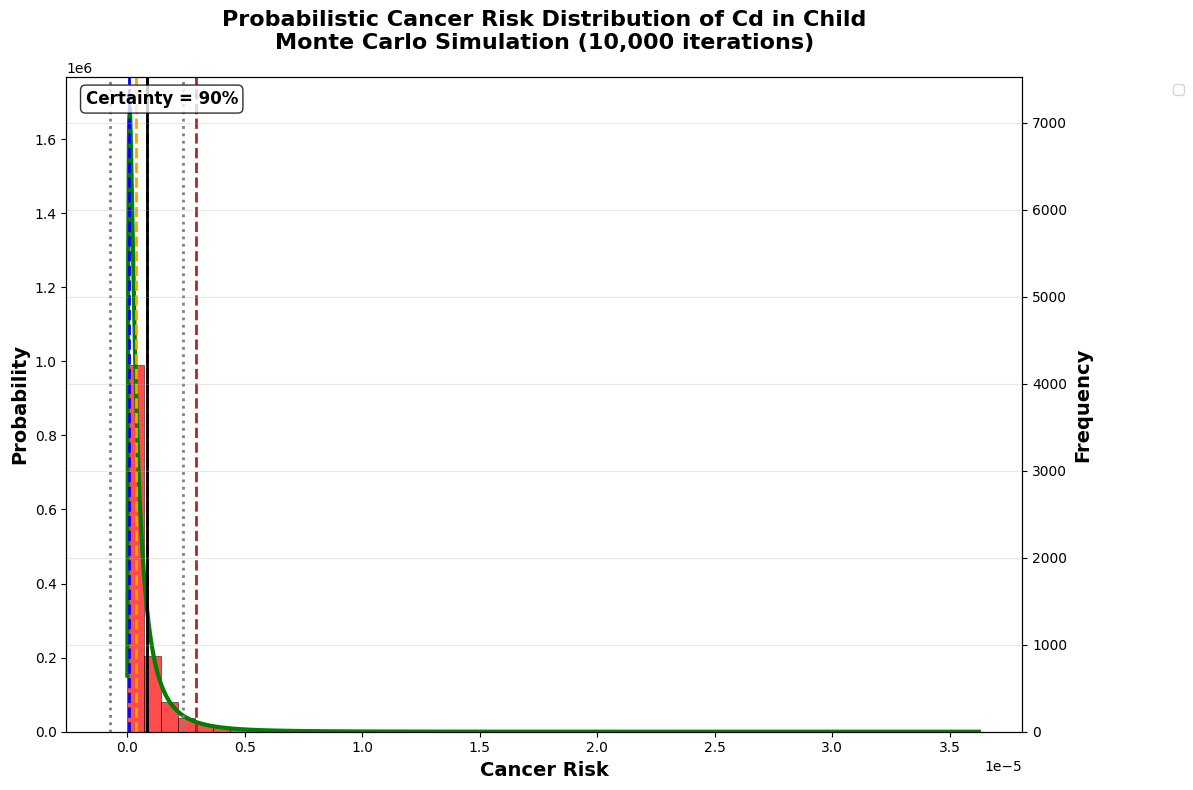


Cd - Child Statistics:
Mean: 8.233e-07
Std: 1.559e-06
5th percentile: 6.737e-08
50th percentile: 3.707e-07
75th percentile: 8.328e-07
95th percentile: 2.929e-06
--------------------------------------------------
Saved: Cr_Adult_CancerRisk.png


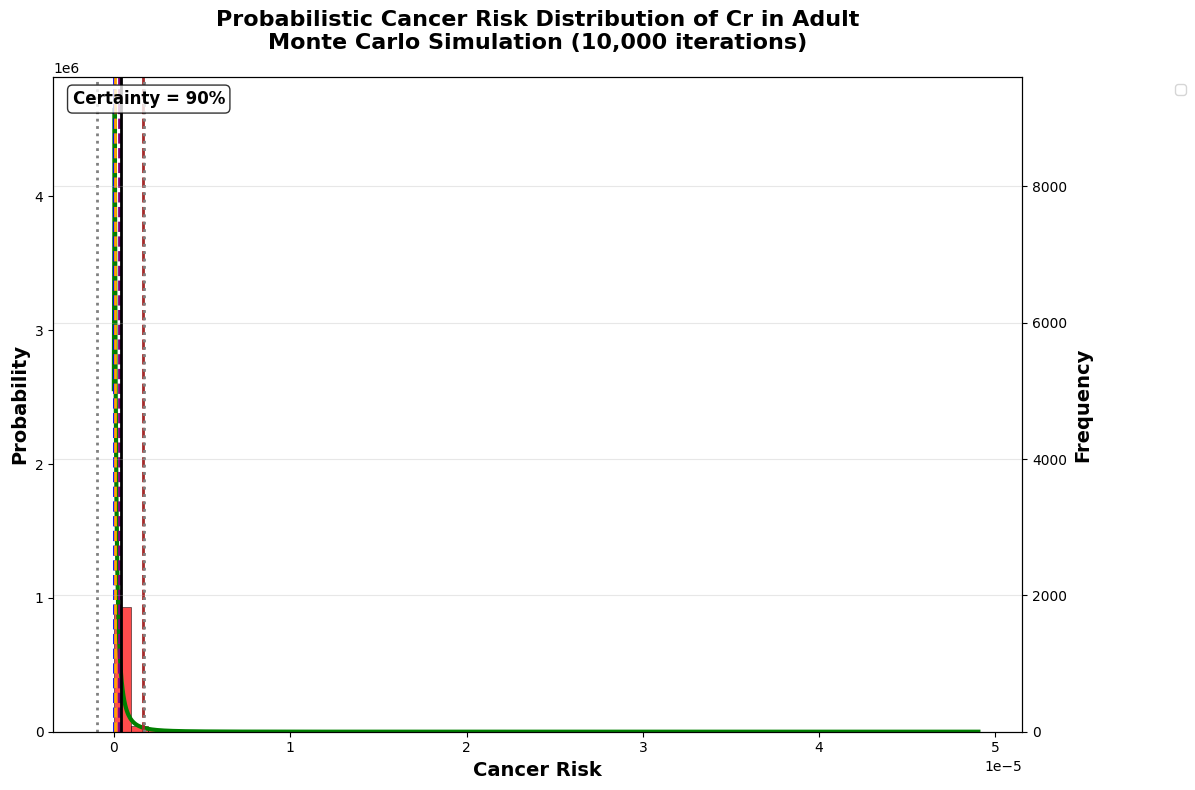


Cr - Adult Statistics:
Mean: 3.969e-07
Std: 1.340e-06
5th percentile: 1.092e-08
50th percentile: 9.245e-08
75th percentile: 2.717e-07
95th percentile: 1.645e-06
--------------------------------------------------
Saved: Cr_Child_CancerRisk.png


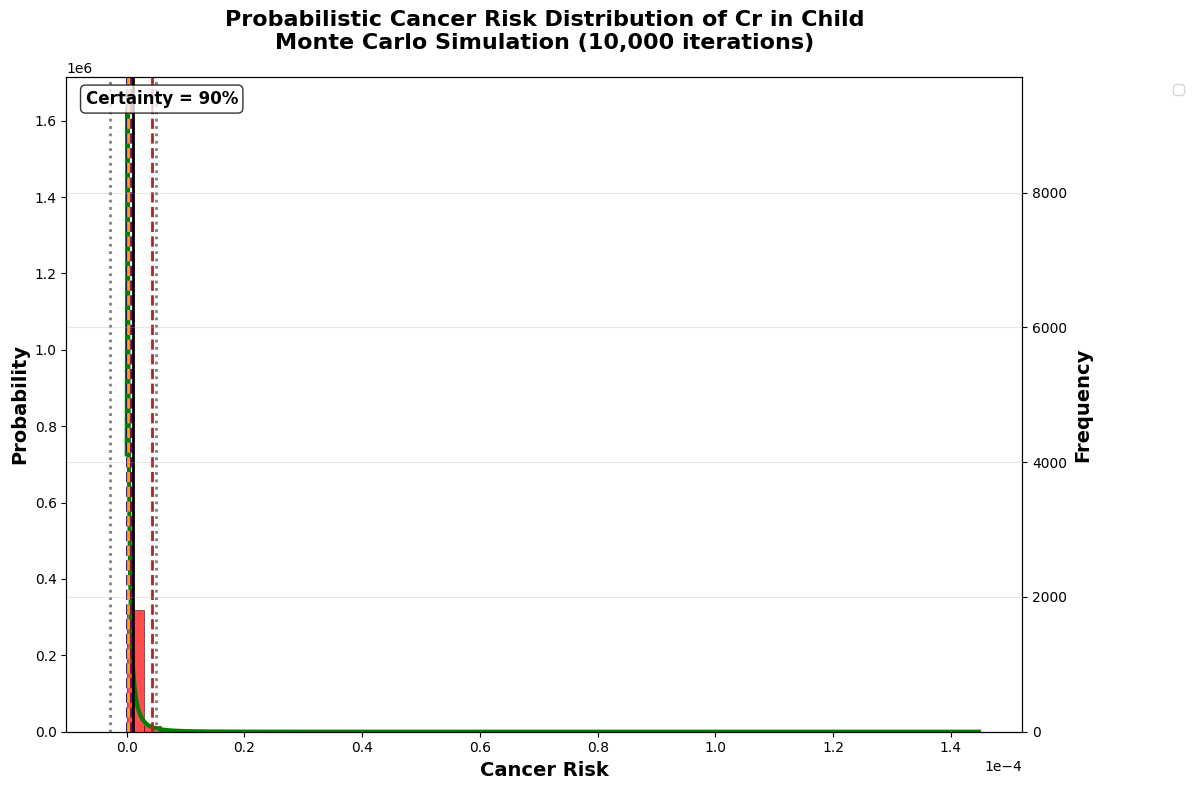


Cr - Child Statistics:
Mean: 1.068e-06
Std: 3.935e-06
5th percentile: 2.834e-08
50th percentile: 2.542e-07
75th percentile: 7.485e-07
95th percentile: 4.236e-06
--------------------------------------------------
Saved: Ni_Adult_CancerRisk.png


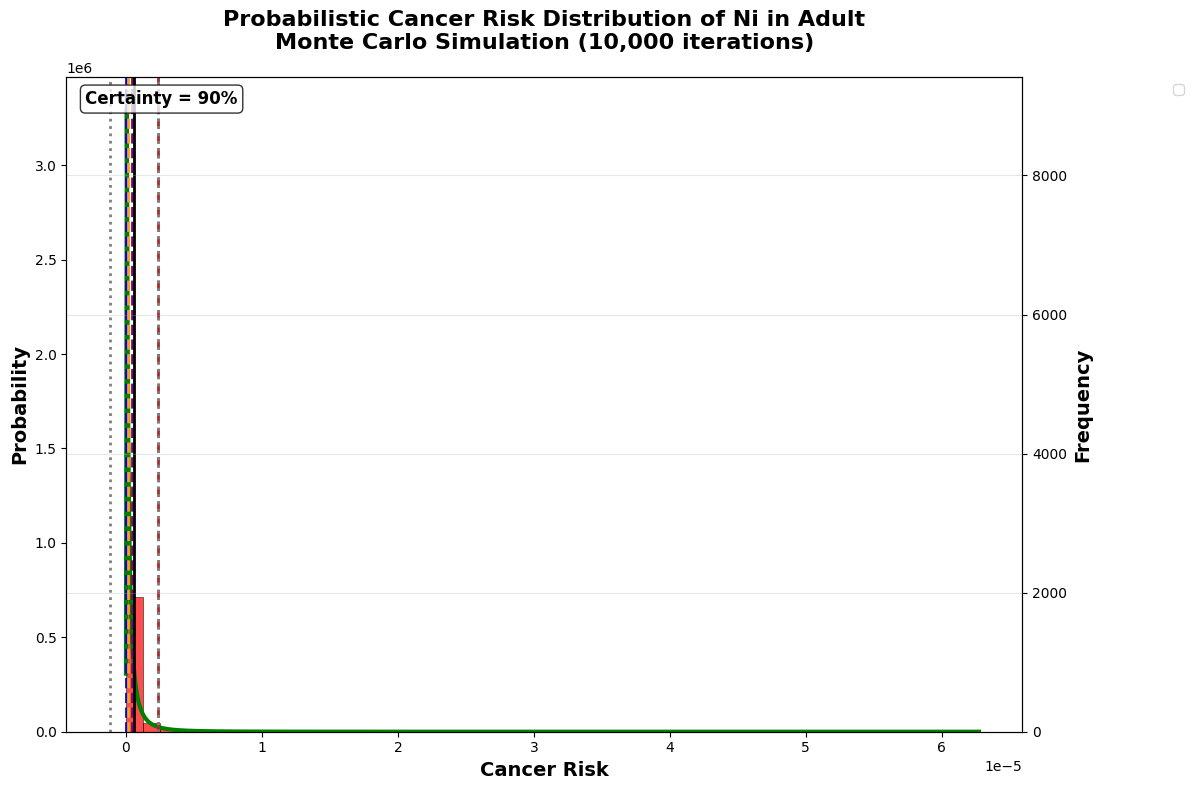


Ni - Adult Statistics:
Mean: 6.006e-07
Std: 1.792e-06
5th percentile: 1.813e-08
50th percentile: 1.673e-07
75th percentile: 4.781e-07
95th percentile: 2.330e-06
--------------------------------------------------
Saved: Ni_Child_CancerRisk.png


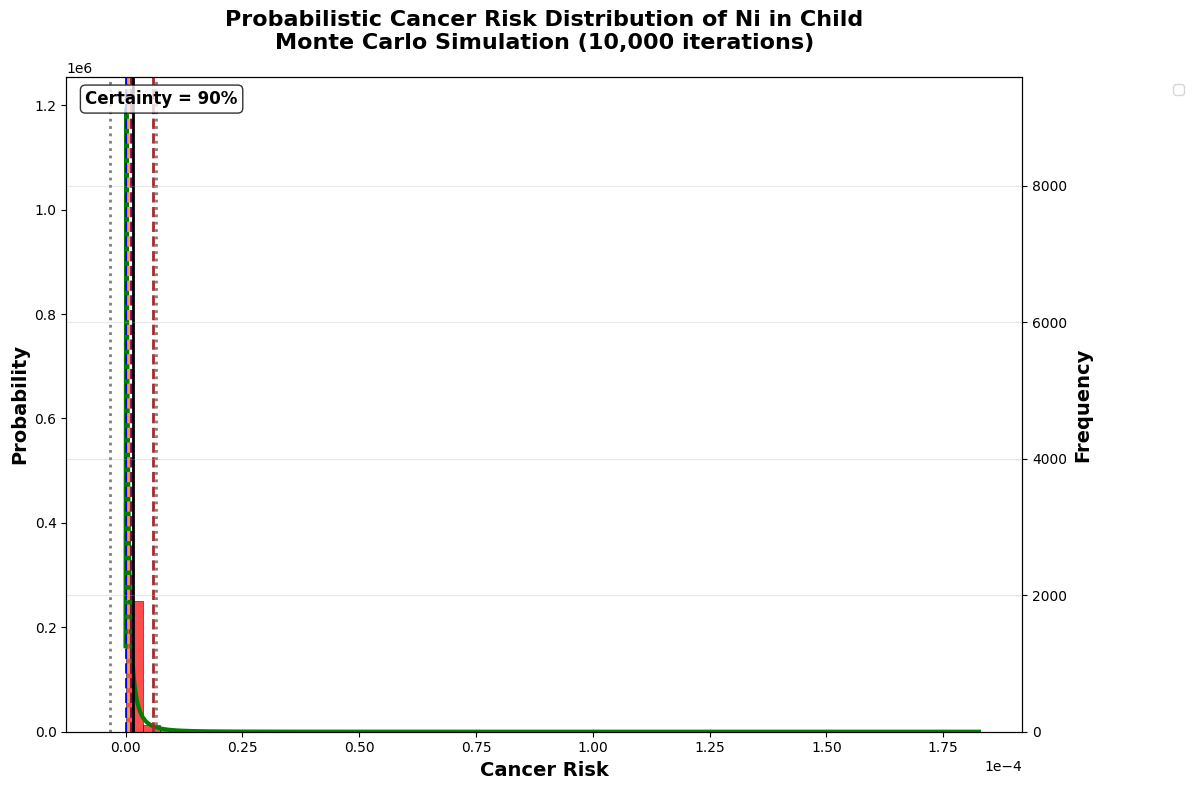


Ni - Child Statistics:
Mean: 1.539e-06
Std: 4.916e-06
5th percentile: 4.611e-08
50th percentile: 4.587e-07
75th percentile: 1.244e-06
95th percentile: 5.782e-06
--------------------------------------------------
Saved: As_Adult_CancerRisk.png


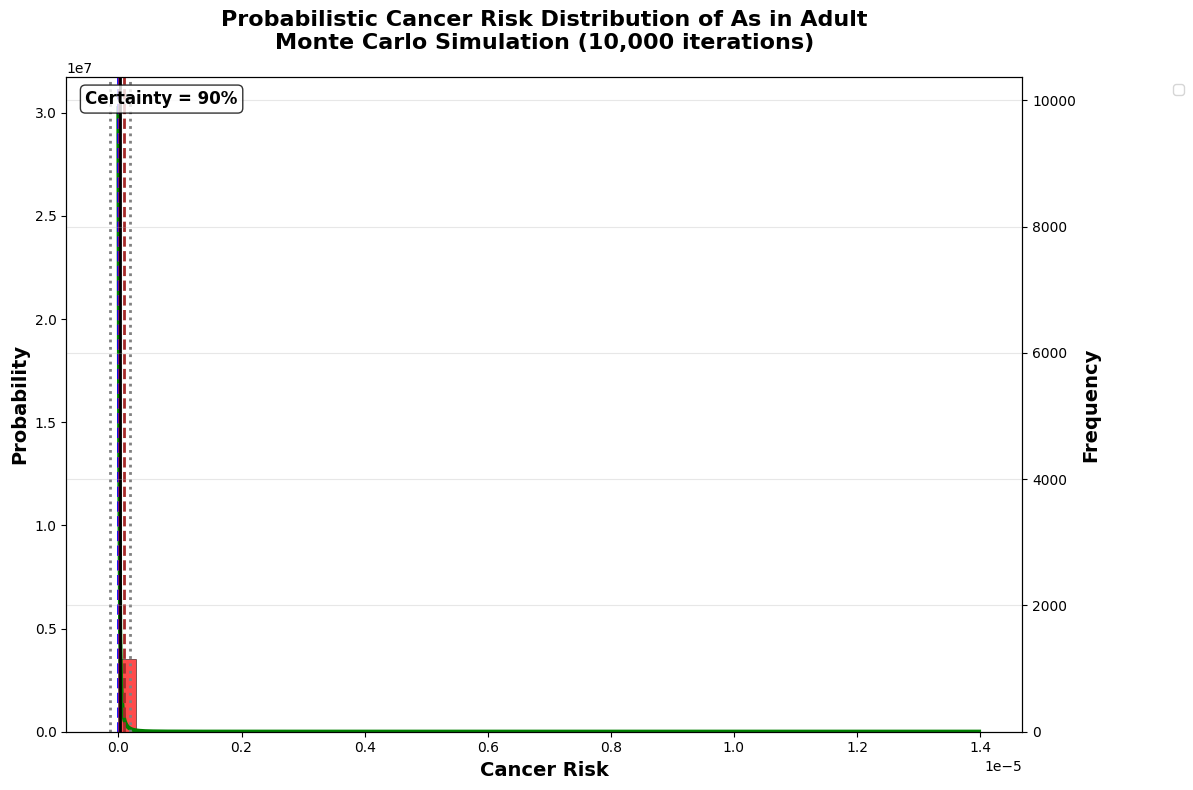


As - Adult Statistics:
Mean: 2.533e-08
Std: 1.664e-07
5th percentile: 2.345e-10
50th percentile: 4.826e-09
75th percentile: 1.632e-08
95th percentile: 9.613e-08
--------------------------------------------------
Saved: As_Child_CancerRisk.png


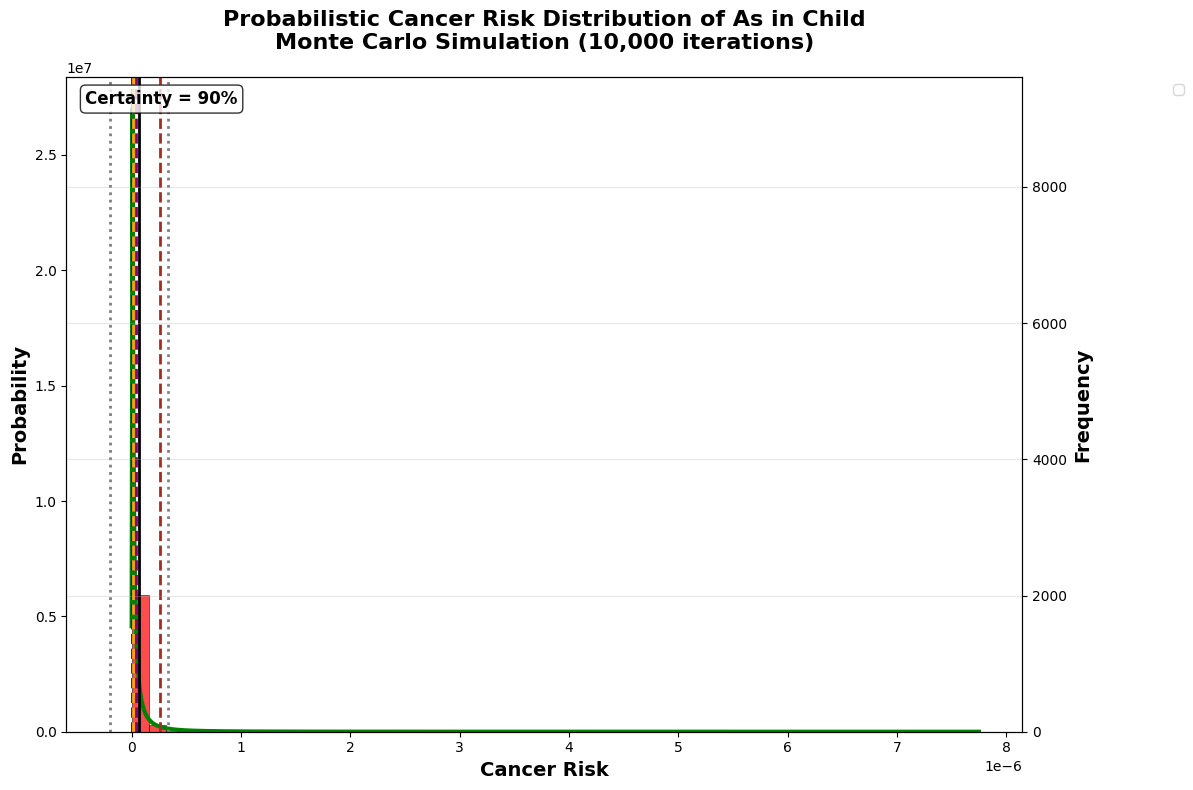


As - Child Statistics:
Mean: 6.792e-08
Std: 2.685e-07
5th percentile: 6.283e-10
50th percentile: 1.245e-08
75th percentile: 4.367e-08
95th percentile: 2.616e-07
--------------------------------------------------

All plots generated successfully!

Files saved:
- Pb_Adult_CancerRisk.png
- Pb_Child_CancerRisk.png
- Cd_Adult_CancerRisk.png
- Cd_Child_CancerRisk.png
- Cr_Adult_CancerRisk.png
- Cr_Child_CancerRisk.png
- Ni_Adult_CancerRisk.png
- Ni_Child_CancerRisk.png
- As_Adult_CancerRisk.png
- As_Child_CancerRisk.png


In [16]:
# Generate all plots
print("\nGenerating plots...")
metals = ['Pb', 'Cd', 'Cr', 'Ni', 'As']
age_groups = ['adult', 'child']

for metal in metals:
    for age_group in age_groups:
        key = f"{metal}_{age_group}"
        if key in simulation_results:
            create_cancer_risk_plot(simulation_results[key], metal, age_group)

print("\nAll plots generated successfully!")
print("\nFiles saved:")
for metal in metals:
    for age_group in age_groups:
        print(f"- {metal}_{age_group.capitalize()}_CancerRisk.png")

In [17]:
def save_analysis_summary_to_excel(simulation_results, filename='Carcinogenic_Monte_Carlo_Analysis_Summary.xlsx'):
    """Save all analysis data and statistics to Excel file"""
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        
        # 1. Summary Statistics Sheet
        summary_stats = []
        raw_data_dict = {}
        
        metals = ['Pb', 'Cd', 'Cr', 'Ni', 'As']
        age_groups = ['adult', 'child']
        
        for metal in metals:
            for age_group in age_groups:
                key = f"{metal}_{age_group}"
                if key in simulation_results:
                    data_raw = simulation_results[key]
                    
                    # Clean data - remove any zeros, negatives, or invalid values
                    data = data_raw[data_raw > 0]
                    invalid_count = len(data_raw) - len(data)
                    
                    if len(data) == 0:
                        print(f"Warning: No valid data for {key}")
                        continue
                    
                    # Original data statistics
                    data_min = data.min()
                    data_max = data.max()
                    data_mean = data.mean()
                    data_std = data.std()
                    
                    # Percentiles
                    perc_5 = np.percentile(data, 5)
                    perc_50 = np.percentile(data, 50)
                    perc_75 = np.percentile(data, 75)
                    perc_90 = np.percentile(data, 90)
                    perc_95 = np.percentile(data, 95)
                    perc_99 = np.percentile(data, 99)
                    
                    # Append to summary
                    summary_stats.append({
                        'Metal': metal,
                        'Age_Group': age_group.capitalize(),
                        'Sample_Size': len(data),
                        'Invalid_Values_Removed': invalid_count,
                        'Min': data_min,
                        'Max': data_max,
                        'Mean': data_mean,
                        'Std_Dev': data_std,
                        '5th_Percentile': perc_5,
                        '50th_Percentile_Median': perc_50,
                        '75th_Percentile': perc_75,
                        '90th_Percentile': perc_90,
                        '95th_Percentile': perc_95,
                        '99th_Percentile': perc_99,
                        'Plot_Range_Max_99th_Perc': perc_99
                    })
                    
                    # Store cleaned data for separate sheets
                    raw_data_dict[f'{metal}_{age_group}'] = data
        
        # Save summary statistics
        summary_df = pd.DataFrame(summary_stats)
        summary_df.to_excel(writer, sheet_name='Summary_Statistics', index=False)
        
        # 2. Raw ILCR Data Sheet
        if raw_data_dict:
            max_length = max([len(data) for data in raw_data_dict.values()])
            raw_data_padded = {}
            
            for key, data in raw_data_dict.items():
                # Pad with NaN to make all columns same length
                padded_data = np.pad(data.astype(float), (0, max_length - len(data)), 
                                   mode='constant', constant_values=np.nan)
                raw_data_padded[key] = padded_data
            
            raw_df = pd.DataFrame(raw_data_padded)
            raw_df.to_excel(writer, sheet_name='Raw_ILCR_Data', index=False)
        
        # 3. Parameters Used Sheet
        parameters_data = []
        if 'PARAMETERS' in globals():
            for age_group in ['adult', 'child']:
                params = PARAMETERS[age_group]
                parameters_data.append({
                    'Age_Group': age_group.capitalize(),
                    'Exposure_Duration_ED_years': params.get('ED', 'N/A'),
                    'Exposure_Frequency_EFr_days_per_year': params.get('EFr', 'N/A'),
                    'Averaging_Time_AT_days': params.get('AT', 'N/A'),
                    'Body_Weight_BW_kg_mean': params.get('BW', 'N/A'),
                    'FIR_Fuchka_kg_per_day': params.get('FIR_fuchka', 'N/A'),
                    'FIR_Tamarind_L_per_day': params.get('FIR_tamarind', 'N/A')
                })
        
        # Add CSF values
        csf_data = []
        if 'CSF' in globals():
            for metal, csf_value in CSF.items():
                csf_data.append({
                    'Metal': metal,
                    'CSF_Ingestion_per_ug_kg_day': csf_value,
                    'Units': '(µg/kg/day)⁻¹'
                })
        
        if parameters_data:
            params_df = pd.DataFrame(parameters_data)
            params_df.to_excel(writer, sheet_name='Input_Parameters', index=False)
            
            if csf_data:
                csf_df = pd.DataFrame(csf_data)
                # Add CSF data to the same sheet with some spacing
                startrow = len(params_df) + 3
                csf_df.to_excel(writer, sheet_name='Input_Parameters', startrow=startrow, index=False)
                
                # Add header for CSF section
                worksheet = writer.sheets['Input_Parameters']
                worksheet.cell(row=startrow, column=1, value='Cancer Slope Factors (CSF):')
        
        # 4. Methodology Sheet
        methodology_info = [
            {'Step': 1, 'Description': 'Monte Carlo Simulation', 'Details': '10,000 iterations per metal-age group'},
            {'Step': 2, 'Description': 'ILCR Calculation', 'Details': 'ILCR = (C × FIR × EFr × ED × CSF) / (BW × AT)'},
            {'Step': 3, 'Description': 'Combined Risk Assessment', 'Details': 'ILCR_total = ILCR_fuchka + ILCR_tamarind'},
            {'Step': 4, 'Description': 'Distribution Fitting', 'Details': 'Lognormal distribution fitted to results'},
            {'Step': 5, 'Description': 'Statistical Analysis', 'Details': 'Percentiles, mean, standard deviation calculated'},
            {'Step': 6, 'Description': 'Visualization', 'Details': 'Probability density and frequency plots generated'}
        ]
        
        methodology_df = pd.DataFrame(methodology_info)
        methodology_df.to_excel(writer, sheet_name='Methodology', index=False)
        
    print(f"\nAnalysis summary saved to: {filename}")
    print("Excel file contains the following sheets:")
    print("1. Summary_Statistics - Complete statistical summary")
    print("2. Raw_ILCR_Data - All Monte Carlo simulation results")
    print("3. Input_Parameters - Parameters and CSF values used")
    print("4. Methodology - Step-by-step process description")

In [18]:
save_analysis_summary_to_excel(simulation_results=simulation_results)


Analysis summary saved to: Carcinogenic_Monte_Carlo_Analysis_Summary.xlsx
Excel file contains the following sheets:
1. Summary_Statistics - Complete statistical summary
2. Raw_ILCR_Data - All Monte Carlo simulation results
3. Input_Parameters - Parameters and CSF values used
4. Methodology - Step-by-step process description
